# Boletín 4: Redes Neuronales

## Importamos las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

## Definimos variables globales

In [3]:
SEED_VALUE = 1  # Valor que se indica en el boletín
DATASET_DELIMITER = ',' # Ambos bloodTransfusion.data y EnergyEfficiency.data lo usan

## Ejercicio 1: Red Neuronal sin scikit-learn

Vamos a definir los datos dados en el boletin

In [4]:
W1 = np.array([[-2, 1], [1, -1], [3, -1]])  # Pesos de la primera capa
W2 = np.array([[2, 3, 1]])                 # Pesos de la segunda capa
b1 = np.array([[0], [-1], [1]])            # Bias de la primera capa
b2 = np.array([[0]])                       # Bias de la segunda capa
a1 = np.array([[1], [1]])  

### Apartado a: Calcula zi(l) y ai(l) para todas las neuronas

Primero necesitamos crear la funcion sigmoide y su derivada

In [5]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def sigmoide_derivada(x):
    return sigmoide(x) * (1 - sigmoide(x))

Ahora calculamos zi y ai

In [6]:
# Forward pass para calcular zi(l) y ai(l)
z2 = np.dot(W1, a1) + b1
a2 = sigmoide(z2)
z3 = np.dot(W2, a2) + b2

# En la capa de salida usamos como funcion de activacion la identidad
a3 = z3  

print(" z2 (valores de z en la capa oculta):")
print(z2)
print("\n a2 (activaciones en la capa oculta):")
print(a2)
print("\n z3 (valor de z en la capa de salida):")
print(z3)
print("\n a3 (activación en la capa de salida):")
print(a3)

 z2 (valores de z en la capa oculta):
[[-1]
 [-1]
 [ 3]]

 a2 (activaciones en la capa oculta):
[[0.26894142]
 [0.26894142]
 [0.95257413]]

 z3 (valor de z en la capa de salida):
[[2.29728123]]

 a3 (activación en la capa de salida):
[[2.29728123]]


### Apartado b: Calcula delta d_i(l) para todas las neuronas

Primero definimos el valor objetivo

In [7]:
y = np.array([[1]]) 

Ahora podemos calcular las deltas para todas las neuronas

In [8]:
# Calculo de errores y deltas (Retro-propagación)

# Primero calculamos el error en la capa de salida
error_salida = a3 - y  

# Como hemos usado para la funcion de activacion la identidad, su derivada es 1 y no hace falta reflejarla
d_3 = error_salida

# Propagamos el error a la capa oculta
error_oculto = np.dot(W2.T, d_3)
d_2 = error_oculto * sigmoide_derivada(z2)

print("d_2 (Error en la capa oculta):")
print(d_2)

print("\nd_3 (Error en la capa de salida):")
print(d_3)

d_2 (Error en la capa oculta):
[[0.51012194]
 [0.76518291]
 [0.05860683]]

d_3 (Error en la capa de salida):
[[1.29728123]]


### Apartado c: Usando el algoritmo de retro-propagación del error, determina los valores finales de cada peso (Wij(l)) y bias (bi(l)) de la red neuronal tras finalizar la primera iteración del algoritmo, asumiendo un valor de λ=1, y una tasa de aprendizaje α=0,5

Primero definimos la tasa de aprendizaje y lambda dados

In [9]:
alpha = 0.5
lamda = 1

Ahora actualizamos W y b

In [10]:
# Capa oculta (con regularizacion)
W1_grad = np.dot(d_2, a1.T) + lamda * W1
b1_grad = d_2

W1_aux = W1 - alpha * W1_grad
b1_aux = b1 - alpha * b1_grad

# Capa de salida (con regularizacion)
W2_grad = np.dot(d_3, a2.T) + lamda * W2
b2_grad = d_3

W2_aux = W2 - alpha * W2_grad
b2_aux = b2 - alpha * b2_grad

Imprimimos los resultados

In [11]:
print("Pesos y bias actualizados después de la primera iteración:")
print(" W1 actualizado:")
print(W1_aux)
print("\n b1 actualizado:")
print(b1_aux)
print("\n W2 actualizado:")
print(W2_aux)
print("\n b2 actualizado:")
print(b2_aux)

Pesos y bias actualizados después de la primera iteración:
 W1 actualizado:
[[-1.25506097  0.24493903]
 [ 0.11740854 -0.88259146]
 [ 1.47069658 -0.52930342]]

 b1 actualizado:
[[-0.25506097]
 [-1.38259146]
 [ 0.97069658]]

 W2 actualizado:
[[ 0.82555367  1.32555367 -0.11787827]]

 b2 actualizado:
[[-0.64864062]]


## Ejercicio 2: Redes neuronales con Blood Transfusion Service Center

In [12]:
df_2 = pd.read_csv("bloodTransfusion.data", 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "DonatedInMarch"])
df_2

Recency  Frequency  Monetary  Time  DonatedInMarch
0          2         50     12500    98               1
1          0         13      3250    28               1
2          1         16      4000    35               1
3          2         20      5000    45               1
4          1         24      6000    77               0
5          4          4      1000     4               0
6          2          7      1750    14               1
7          1         12      3000    35               0
8          2          9      2250    22               1
9          5         46     11500    98               1
10         4         23      5750    58               0
11         0          3       750     4               0
12         2         10      2500    28               1
13         1         13      3250    47               0
14         2          6      1500    15               1
15         2          5      1250    11               1
16         2         14      3500    48               1
17         2         15      3750    49               1
18         2          6      1500    15               1
19         2          3       750     4               1
20         2          3       750     4               1
21         4         11      2750    28               0
22         2          6      1500    16               1
23         2          6      1500    16               1
24         9          9      2250    16               0
25         4         14      3500    40               0
26         4          6      1500    14               0
27         4         12      3000    34               1
28         4          5      1250    11               1
29         4          8      2000    21               0
..       ...        ...       ...   ...             ...
718       21          3       750    35               0
719       23          8      2000    69               0
720       21          3       750    38               0
721       23          3       750    35               0
722       21          3       750    40               0
723       23          2       500    28               0
724       21          1       250    21               0
725       21          1       250    21               0
726       25          6      1500    50               0
727       21          1       250    21               0
728       21          1       250    21               0
729       23          3       750    39               0
730       21          2       500    33               0
731       14          3       750    79               0
732       23          1       250    23               1
733       23          1       250    23               0
734       23          1       250    23               0
735       23          1       250    23               0
736       23          1       250    23               0
737       23          1       250    23               0
738       23          1       250    23               0
739       23          4      1000    52               0
740       23          1       250    23               0
741       23          7      1750    88               0
742       16          3       750    86               0
743       23          2       500    38               0
744       21          2       500    52               0
745       23          3       750    62               0
746       39          1       250    39               0
747       72          1       250    72               0

[748 rows x 5 columns]

### Apartado a: La clase que implementa el Perceptrón multicapa (MLP) en problemas de clasificación en scikit-learn es sklearn.neural_network.MLPClassifier. Revisa los parámetros y métodos que tiene

In [13]:
help(MLPClassifier)

Help on class MLPClassifier in module sklearn.neural_network.multilayer_perceptron:

class MLPClassifier(BaseMultilayerPerceptron, sklearn.base.ClassifierMixin)
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 'logistic', 'tanh', 'relu'}, default 'relu'
 |      Activation function for the hidden layer.
 |  
 |      - 'identity', no-op activation, useful to implement linear bottleneck,
 |        returns f(x) = x
 |  
 |      - 'logistic', the logistic sigmoid function,
 |        returns f(x) = 1 / (1 + exp(-x)).
 |  
 |      - 'tanh', the hyperbolic tan function,
 |        returns f(x) = tanh(x).
 |  
 |      - 'relu', the rectified linear u

### Apartado b: Divide los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en variables predictoras X y la variable dependiente Y

In [14]:
X = df_2.drop('DonatedInMarch', axis=1)
Y = df_2['DonatedInMarch']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED_VALUE, stratify=Y)

Vamos también a estandarizar los datos, en este caso solo las variables predictoras ya que se trata de un problema de clasificación.

In [15]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


### Apartado c: Realiza la experimentación con MLPClassifier usando los valores por defecto de los parámetros, excepto para activation=’tanh y solver=’lbfgs’, y max_iter=2000

In [16]:
# Configuramos los hiperparametros a probar
hidden_layer_sizes = [(n,) * l for l in range(1, 4) for n in range(1, 21)]  # 1-20 neuronas, 1-3 capas
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
hyperparameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alphas}

print(hyperparameters)

{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (1, 1, 1), (2, 2, 2), (3, 3, 3), (4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7), (8, 8, 8), (9, 9, 9), (10, 10, 10), (11, 11, 11), (12, 12, 12), (13, 13, 13), (14, 14, 14), (15, 15, 15), (16, 16, 16), (17, 17, 17), (18, 18, 18), (19, 19, 19), (20, 20, 20)]}


Ahora ejecutamos el entrenamiento:

In [17]:
neural_network = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)
modelCV = GridSearchCV(neural_network,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       return_train_score=True,
                       n_jobs=-1)

np.random.seed(SEED_VALUE)
modelCV.fit(X_train_scaled, Y_train)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, ..., (14, 14, 14), (15, 15, 15), (16, 16, 16), (17, 17, 17), (18, 18, 18), (19, 19, 19), (20, 20, 20)]},
       pre_dispat

Ahora podemos consultar los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [18]:
cv_results = pd.DataFrame(modelCV.cv_results_)
# Si hacemos aqui la transformacion del error es mucho mas comódo
cv_results['mean_test_score'] = 1 - cv_results['mean_test_score']
cv_results.loc[:,
               ['param_hidden_layer_sizes', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']
              ].sort_values(by='rank_test_score')

param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
302                     (3,)         0.5         0.193980        0.032928   
381                   (2, 2)           1         0.197324        0.027380   
301                     (2,)         0.5         0.197324        0.028093   
242                     (3,)         0.1         0.197324        0.024302   
201                   (2, 2)        0.05         0.198997        0.032680   
321                   (2, 2)         0.5         0.198997        0.020934   
181                     (2,)        0.05         0.198997        0.030962   
241                     (2,)         0.1         0.198997        0.017331   
41                 (2, 2, 2)       0.001         0.198997        0.019710   
21                    (2, 2)       0.001         0.198997        0.026695   
202                   (3, 3)        0.05         0.198997        0.026109   
261                   (2, 2)         0.1         0.200669        0.028702   
316                    (17,)         0.5         0.200669        0.021329   
362                     (3,)           1         0.200669        0.031238   
306                     (7,)         0.5         0.200669        0.022855   
305                     (6,)         0.5         0.200669        0.021329   
361                     (2,)           1         0.200669        0.028090   
369                    (10,)           1         0.202341        0.024356   
363                     (4,)           1         0.202341        0.028495   
184                     (5,)        0.05         0.202341        0.025520   
182                     (3,)        0.05         0.202341        0.019718   
461                (2, 2, 2)           5         0.202341        0.032289   
382                   (3, 3)           1         0.202341        0.020172   
378                    (19,)           1         0.202341        0.023397   
262                   (3, 3)         0.1         0.202341        0.021470   
367                     (8,)           1         0.202341        0.024356   
312                    (13,)         0.5         0.202341        0.023173   
384                   (5, 5)           1         0.202341        0.016517   
308                     (9,)         0.5         0.202341        0.016388   
376                    (17,)           1         0.202341        0.024356   
..                       ...         ...              ...             ...   
289             (10, 10, 10)         0.1         0.304348        0.050273   
297             (18, 18, 18)         0.1         0.304348        0.037304   
152                 (13, 13)        0.01         0.304348        0.026655   
211                 (12, 12)        0.05         0.306020        0.024201   
59              (20, 20, 20)       0.001         0.306020        0.032807   
154                 (15, 15)        0.01         0.306020        0.051316   
277                 (18, 18)         0.1         0.306020        0.041464   
139                    (20,)        0.01         0.306020        0.053481   
212                 (13, 13)        0.05         0.306020        0.041895   
239             (20, 20, 20)        0.05         0.307692        0.052005   
298             (19, 19, 19)         0.1         0.307692        0.034261   
269                 (10, 10)         0.1         0.307692        0.055464   
234             (15, 15, 15)        0.05         0.307692        0.056013   
219                 (20, 20)        0.05         0.307692        0.033456   
348                (9, 9, 9)         0.5         0.307692        0.050972   
37                  (18, 18)       0.001         0.307692        0.034634   
236             (17, 17, 17)        0.05         0.309365        0.039241   
272                 (13, 13)         0.1         0.309365        0.043032   
114             (15, 15, 15)       0.005         0.309365        0.050791   
34                  (15, 15)       0.001         0.309365        0.034186   


**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros, y justifica la elección de los valores más apropiados. Para cada combinación de valor del número de capas ocultas y parámetro de regularización se debe generar una gráfica donde se represente en el eje horizontal el número de neuronas en la capa oculta.**

In [19]:
# Funcion para extraer el numero de neuronas de una tupla de tamaño de capas ocultas
def extract_neurons(hidden_layer_tuple):
    if len(hidden_layer_tuple) > 0:
        return hidden_layer_tuple[0]
    else:
        return 0
    
def extract_n_layers(hidden_layer_tuple):
    return len(hidden_layer_tuple)

In [20]:
# Añadimos columnas para el numero de neuronas y de capas
cv_results['n_neurons'] = cv_results['param_hidden_layer_sizes'].apply(extract_neurons)
cv_results['n_layers'] = cv_results['param_hidden_layer_sizes'].apply(extract_n_layers)

# Obtenemos los valores unicos de alpha y numero de capas
unique_alphas = cv_results['param_alpha'].unique()
unique_layer_counts = cv_results['n_layers'].unique()

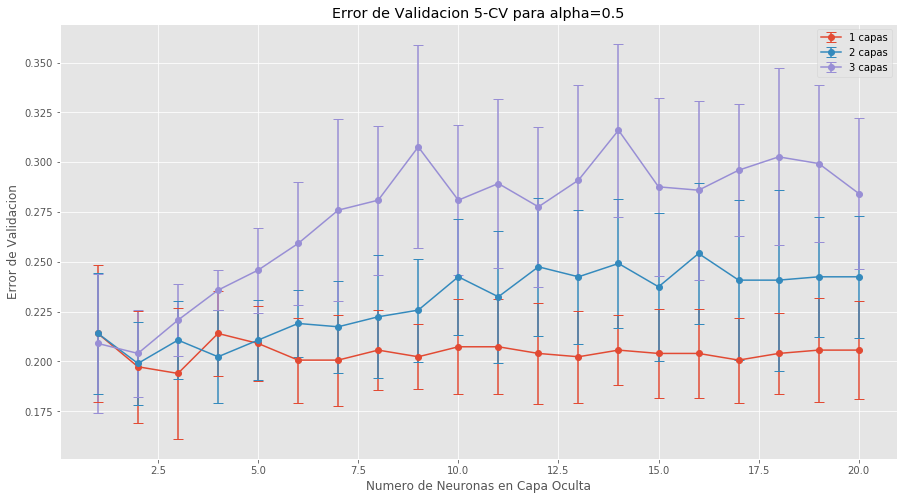

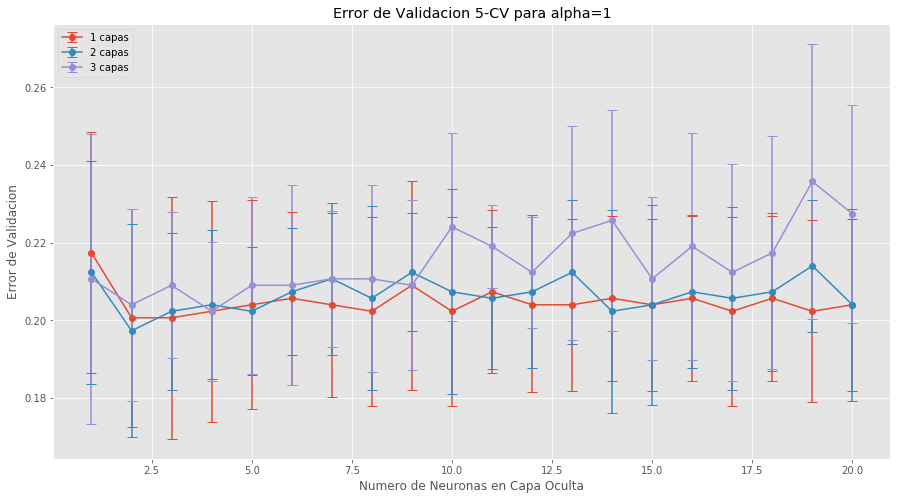

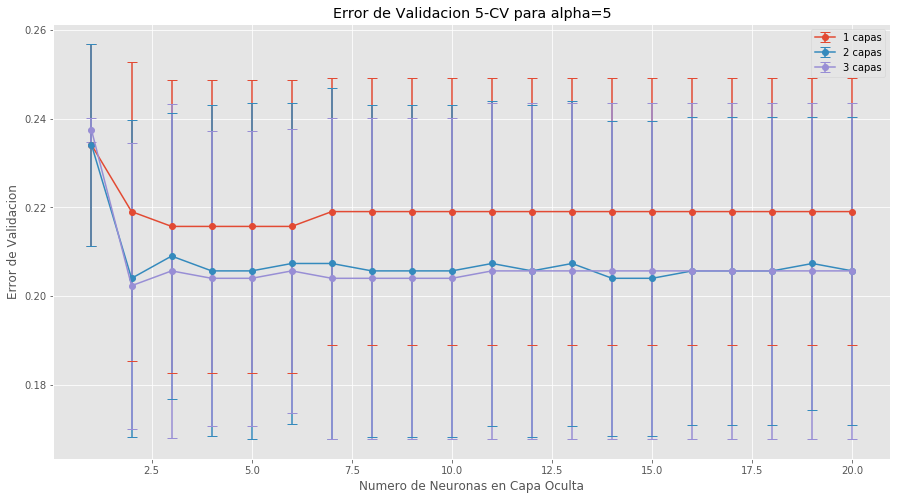

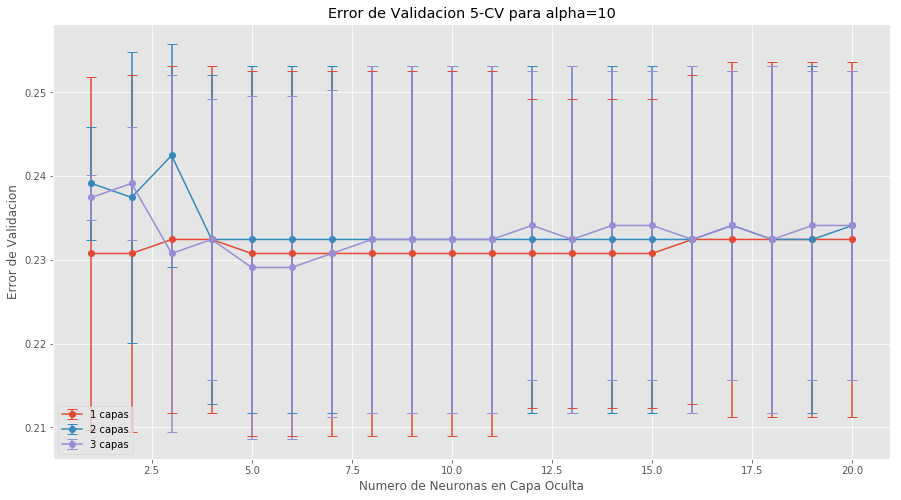

In [21]:
# Creamos un grafico para cada valor de alpha
for alpha in unique_alphas:
    plt.figure(figsize=(15, 8))
    
    for layer_count in unique_layer_counts:
        # Filtramos los resultados para una combinación específica de alpha y número de capas
        subset = cv_results[(cv_results['param_alpha'] == alpha) & (cv_results['n_layers'] == layer_count)]

        if not subset.empty:
            plt.errorbar(subset['n_neurons'], 
                         subset['mean_test_score'], 
                         yerr=subset['std_test_score'], 
                         fmt='-o', 
                         capsize=5,
                         label="{} capas".format(layer_count))

    plt.title("Error de Validacion 5-CV para alpha={}".format(alpha))
    plt.xlabel("Numero de Neuronas en Capa Oculta")
    plt.ylabel("Error de Validacion")
    plt.legend()
    plt.show()

Hemos realizado el estudio de los datos para alpha: [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], de 1 a tres capas y de 1 a 20 neuronas por capa. De forma general, el aumento de neuronas por capa a partir de 7 por capa solo empeora o mantiene el resultado y, además, en todos los casos excepto para alpha = 5 el los mejores resultados son generados con una sola capa oculta. También es muy relevante que a partir de alpha = 0.5 la evolución del error empieza a tender a un solo valor y para alpha = 5 y alpha = 10 las gráficas se componen de básicamente 3 líneas horizontales.

Con los valores obtenidos, podemos afirmar que los mejores valores se generan con 1 capa oculta con 7 o menos neuronas y alpha en la magnitud de 0.5 e inferior. 

Datos del Hiperparámetro con menor error de validación cruzada y mas simple

In [22]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
best = cv_results_best.loc[:,
                    ['param_hidden_layer_sizes', 'param_alpha',  'n_layers',  'n_neurons',
                     'mean_test_score', 'std_test_score', 'rank_test_score']
                   ].sort_values(by='param_hidden_layer_sizes', ascending=False
                    ).head(1)
best

param_hidden_layer_sizes param_alpha  n_layers  n_neurons  \
302                     (3,)         0.5         1          3   

     mean_test_score  std_test_score  rank_test_score  
302          0.19398        0.032928                1

**Muestra la gráfica del error de test frente al valor de los hiper‐parámetros (siguiendo el mismo esquema que en el apartado anterior), y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**

In [23]:
# Preparar los datos para el gráfico
unique_alphas = cv_results['param_alpha'].unique()
unique_layer_counts = cv_results['n_layers'].unique()

# Calcular los errores de test
test_errors = {alpha: {layer_count: [] for layer_count in unique_layer_counts} for alpha in unique_alphas}

for index, row in cv_results.iterrows():
    params = row['params']
    alpha = params['alpha']
    layer_count = len(params['hidden_layer_sizes'])

    model = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE, **params)
    model.fit(X_train_scaled, Y_train)
    Y_pred_test = model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(Y_test, Y_pred_test)

    test_errors[alpha][layer_count].append((row['n_neurons'], test_error))

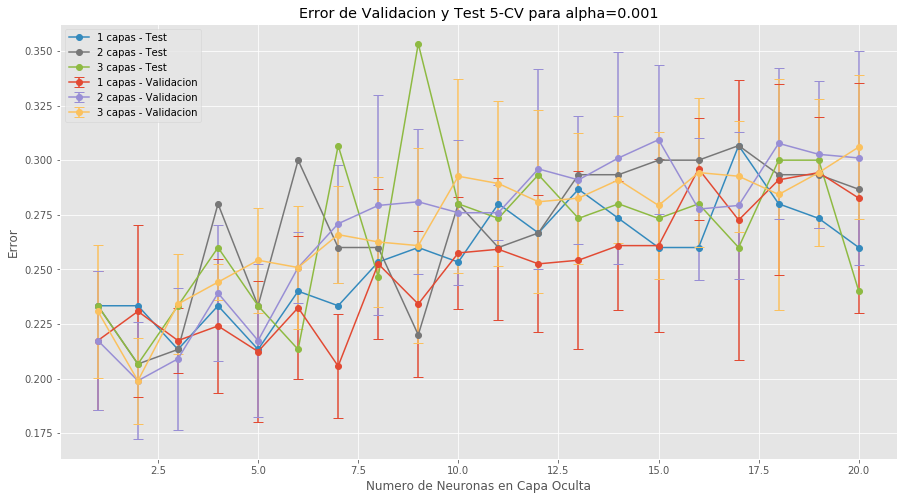

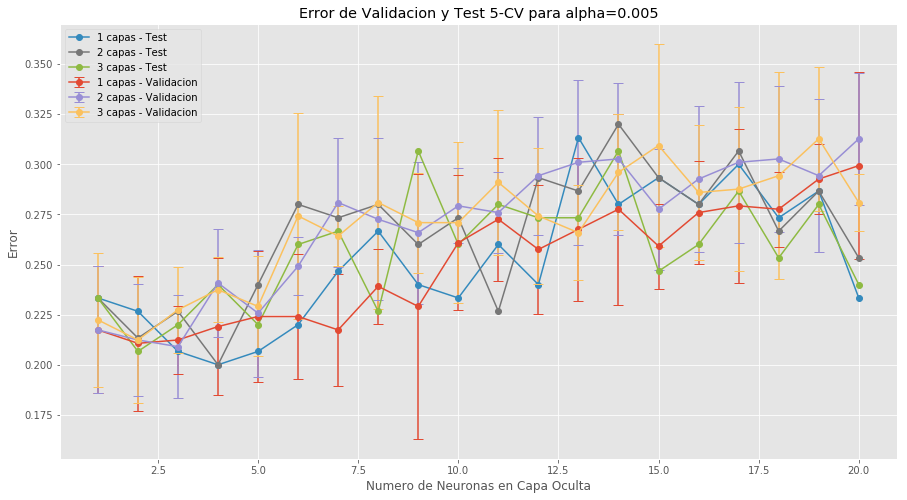

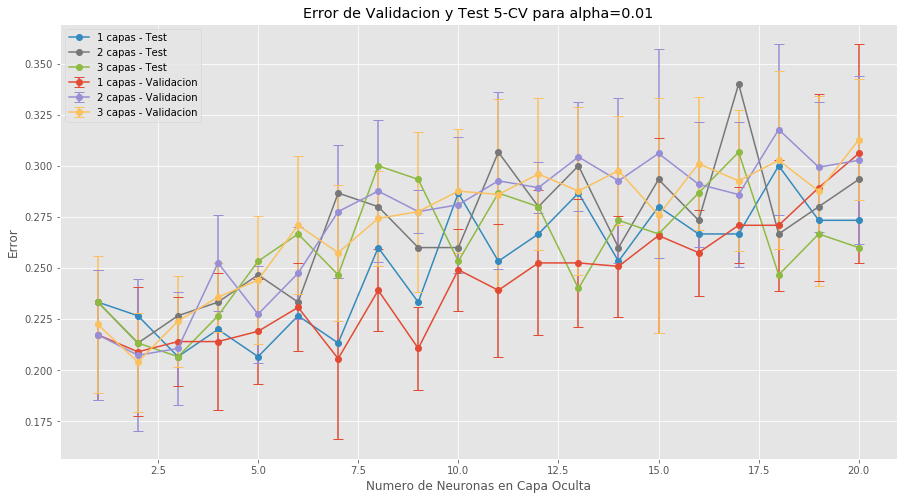

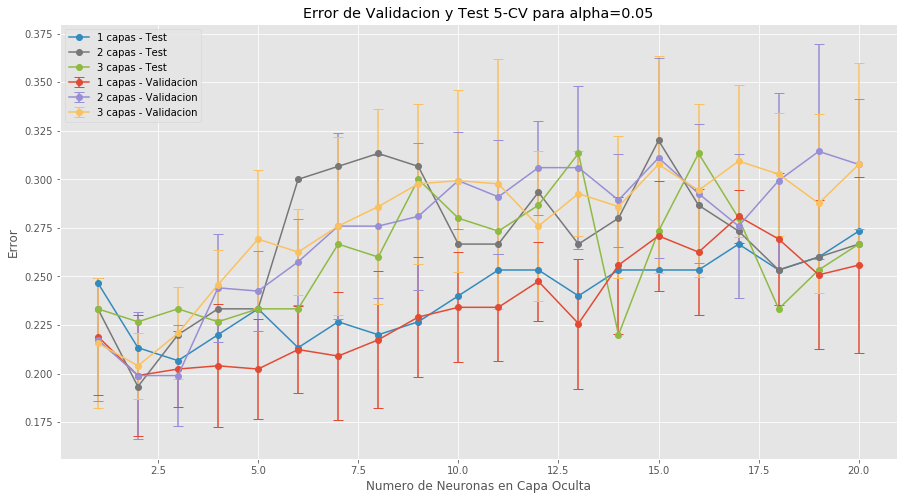

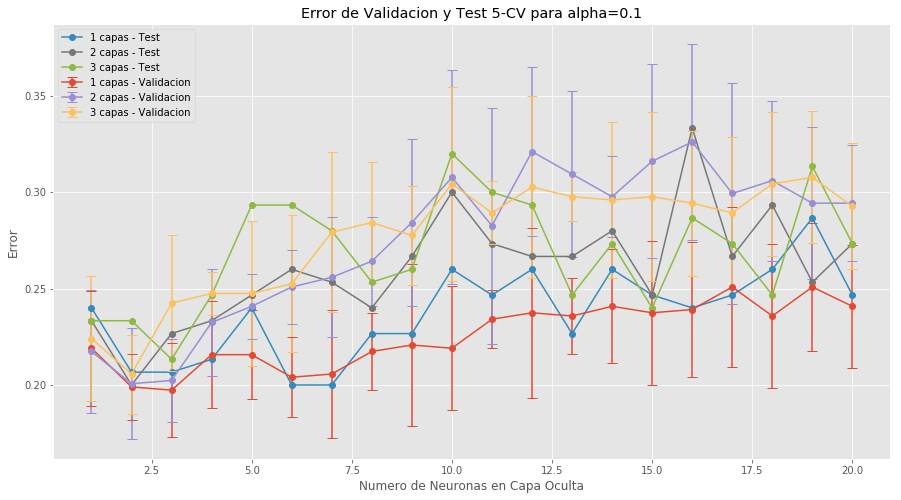

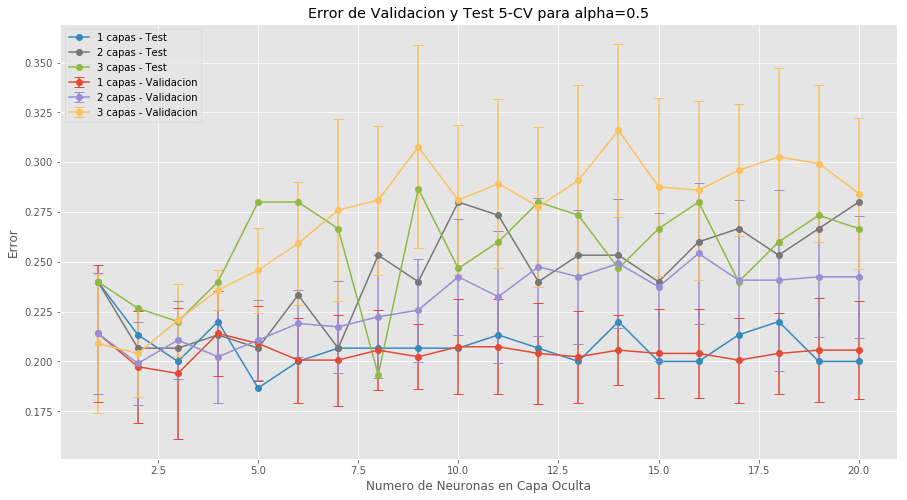

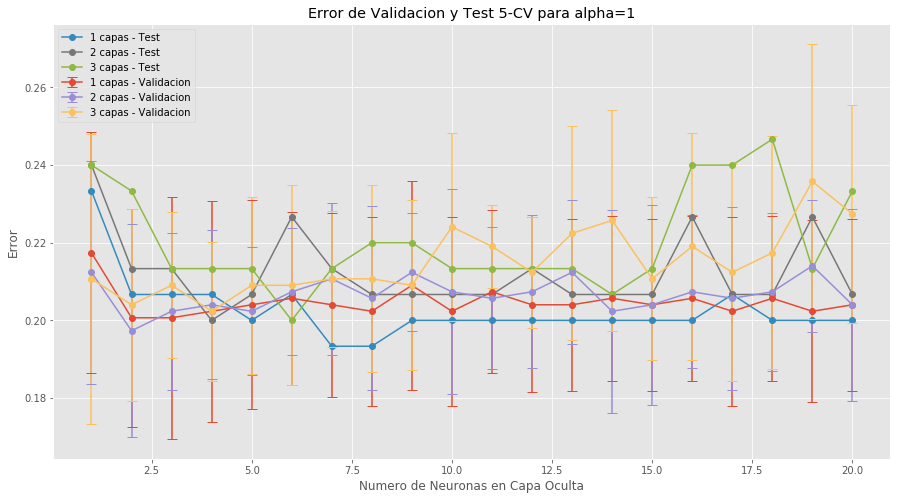

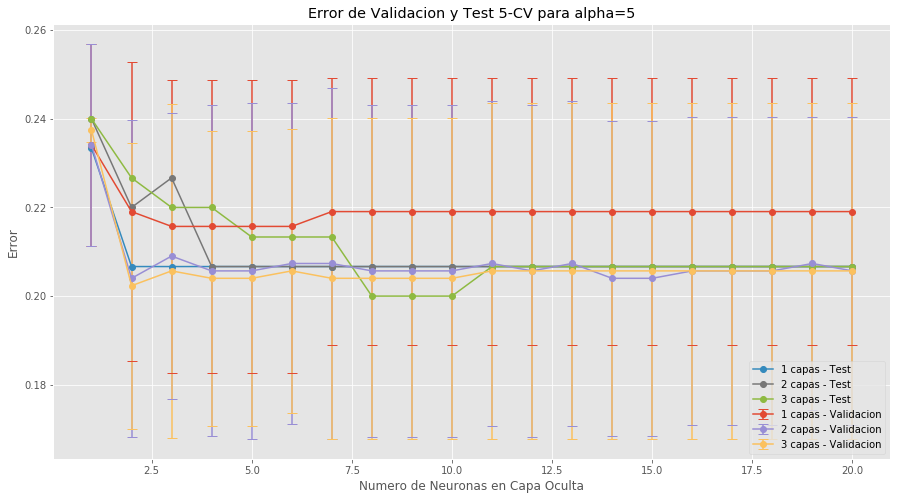

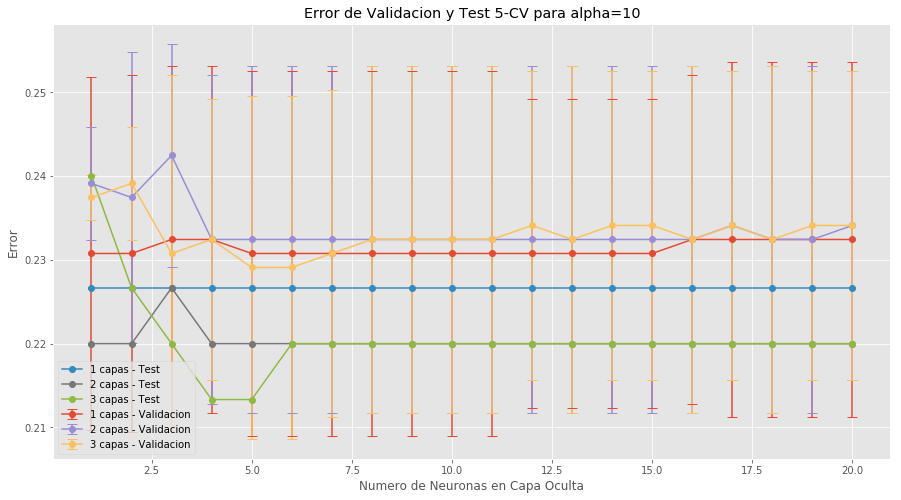

In [24]:
# Crear un gráfico para cada valor de alpha
for alpha in unique_alphas:
    plt.figure(figsize=(15, 8))

    for layer_count in unique_layer_counts:
        # Filtrar los resultados para una combinación específica de alpha y número de capas
        subset = cv_results[(cv_results['param_alpha'] == alpha) & (cv_results['n_layers'] == layer_count)]

        if not subset.empty:
            # Gráfico de error de validación
            plt.errorbar(subset['n_neurons'], 
                         subset['mean_test_score'], 
                         yerr=subset['std_test_score'], 
                         fmt='-o', 
                         capsize=5,
                         label="{} capas - Validacion".format(layer_count))

            # Gráfico de error de test
            test_error_data = test_errors[alpha][layer_count]
            if test_error_data:
                neurons, test_error_values = zip(*test_error_data)
                plt.plot(neurons, test_error_values, label="{} capas - Test".format(layer_count), marker='o')

    plt.title("Error de Validacion y Test 5-CV para alpha={}".format(alpha))
    plt.xlabel("Numero de Neuronas en Capa Oculta")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

En general los test se han mantenido cerca en distancia y forma de las predicciones para 1 capa oculta, pero para 2 y para 3 capas ocultas el resultado no es muy bueno y la funcion de test para esas capas presenta picos intermitentes por todas las graficas.

Ahora podemos extraer el valor del error de test para alpha = 0.5, capa oculta = 1 y 3 neuronas, el que obtuvo el mejor error de validación

In [25]:
print("Error de test para el mejor modelo seleccionado por validación cruzada")
print(test_errors[0.5][1][2])

Error de test para el mejor modelo seleccionado por validación cruzada
(3, 0.19999999999999996)


Vamos a extraer el menor valor de test:

In [26]:
def encontrar_minimo_error(test_error_data):
    # Inicializar variables para almacenar el mínimo error y sus correspondientes valores
    min_error = float('inf')
    min_error_details = {}

    # Iterar a través de los datos para encontrar el mínimo error
    for alpha, layers in test_error_data.items():
        for n_layer, neuron_error_list in layers.items():
            for n_neurons, error in neuron_error_list:
                if error < min_error:
                    min_error = error
                    min_error_details = {
                        'alpha': alpha,
                        'n_layer': n_layer,
                        'n_neurons': n_neurons,
                        'error': error
                    }

    return min_error_details

In [28]:
encontrar_minimo_error(test_errors)

{'alpha': 0.5, 'error': 0.18666666666666665, 'n_layer': 1, 'n_neurons': 5}

## Ejercicio 3: Repite el ejercicio 2 pero para el problema de regresión Energy Efficiency con la variable de salida (Y2)

Primero vamos a importar, mostrar y estudiar los datos. Especificamos el nombre de las columnas para evitar errores con espacion inesperados.

In [29]:
df_3 = pd.read_csv("EnergyEfficiency.data", 
                      delimiter=DATASET_DELIMITER,
                       skiprows=1,
                       header=None,
                       names=["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y2"])
df_3

X1     X2     X3      X4   X5  X6   X7  X8     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  28.28
5    0.90  563.5  318.5  122.50  7.0   3  0.0   0  25.38
6    0.90  563.5  318.5  122.50  7.0   4  0.0   0  25.16
7    0.90  563.5  318.5  122.50  7.0   5  0.0   0  29.60
8    0.86  588.0  294.0  147.00  7.0   2  0.0   0  27.30
9    0.86  588.0  294.0  147.00  7.0   3  0.0   0  21.97
10   0.86  588.0  294.0  147.00  7.0   4  0.0   0  23.49
11   0.86  588.0  294.0  147.00  7.0   5  0.0   0  27.87
12   0.82  612.5  318.5  147.00  7.0   2  0.0   0  23.77
13   0.82  612.5  318.5  147.00  7.0   3  0.0   0  21.46
14   0.82  612.5  318.5  147.00  7.0   4  0.0   0  21.16
15   0.82  612.5  318.5  147.00  7.0   5  0.0   0  24.93
16   0.79  637.0  343.0  147.00  7.0   2  0.0   0  37.73
17   0.79  637.0  343.0  147.00  7.0   3  0.0   0  31.27
18   0.79  637.0  343.0  147.00  7.0   4  0.0   0  30.93
19   0.79  637.0  343.0  147.00  7.0   5  0.0   0  39.44
20   0.76  661.5  416.5  122.50  7.0   2  0.0   0  29.79
21   0.76  661.5  416.5  122.50  7.0   3  0.0   0  29.68
22   0.76  661.5  416.5  122.50  7.0   4  0.0   0  29.79
23   0.76  661.5  416.5  122.50  7.0   5  0.0   0  29.40
24   0.74  686.0  245.0  220.50  3.5   2  0.0   0  10.90
25   0.74  686.0  245.0  220.50  3.5   3  0.0   0  11.19
26   0.74  686.0  245.0  220.50  3.5   4  0.0   0  10.94
27   0.74  686.0  245.0  220.50  3.5   5  0.0   0  11.17
28   0.71  710.5  269.5  220.50  3.5   2  0.0   0  11.27
29   0.71  710.5  269.5  220.50  3.5   3  0.0   0  11.72
..    ...    ...    ...     ...  ...  ..  ...  ..    ...
738  0.79  637.0  343.0  147.00  7.0   4  0.4   5  47.01
739  0.79  637.0  343.0  147.00  7.0   5  0.4   5  44.87
740  0.76  661.5  416.5  122.50  7.0   2  0.4   5  39.37
741  0.76  661.5  416.5  122.50  7.0   3  0.4   5  39.80
742  0.76  661.5  416.5  122.50  7.0   4  0.4   5  37.79
743  0.76  661.5  416.5  122.50  7.0   5  0.4   5  38.18
744  0.74  686.0  245.0  220.50  3.5   2  0.4   5  16.69
745  0.74  686.0  245.0  220.50  3.5   3  0.4   5  16.62
746  0.74  686.0  245.0  220.50  3.5   4  0.4   5  16.94
747  0.74  686.0  245.0  220.50  3.5   5  0.4   5  16.70
748  0.71  710.5  269.5  220.50  3.5   2  0.4   5  15.59
749  0.71  710.5  269.5  220.50  3.5   3  0.4   5  14.58
750  0.71  710.5  269.5  220.50  3.5   4  0.4   5  15.33
751  0.71  710.5  269.5  220.50  3.5   5  0.4   5  15.31
752  0.69  735.0  294.0  220.50  3.5   2  0.4   5  16.63
753  0.69  735.0  294.0  220.50  3.5   3  0.4   5  15.87
754  0.69  735.0  294.0  220.50  3.5   4  0.4   5  16.54
755  0.69  735.0  294.0  220.50  3.5   5  0.4   5  16.74
756  0.66  759.5  318.5  220.50  3.5   2  0.4   5  17.64
757  0.66  759.5  318.5  220.50  3.5   3  0.4   5  17.79
758  0.66  759.5  318.5  220.50  3.5   4  0.4   5  17.55
759  0.66  759.5  318.5  220.50  3.5   5  0.4   5  18.06
760  0.64  784.0  343.0  220.50  3.5   2  0.4   5  20.82
761  0.64  784.0  343.0  220.50  3.5   3  0.4   5  20.21
762  0.64  784.0  343.0  220.50  3.5   4  0.4   5  20.71
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.03

[768 rows x 9 columns]

Vamos a dividir los datos en entrada X y salida Y ademas de crear la division de entrenamiento y prueba

In [30]:
X = df_3.drop('Y2', axis=1)
Y = df_3['Y2']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED_VALUE)

Vamos a estandarizar tanto X como Y ya que estamos ante un problema de regresión, aunque Y no haria falta

In [69]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# Configuramos los hiperparametros a probar
hidden_layer_sizes = [(n,) * l for l in range(1, 4) for n in range(1, 21)]  # 1-20 neuronas, 1-3 capas
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
hyperparameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alphas}

print(hyperparameters)

{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (1, 1, 1), (2, 2, 2), (3, 3, 3), (4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7), (8, 8, 8), (9, 9, 9), (10, 10, 10), (11, 11, 11), (12, 12, 12), (13, 13, 13), (14, 14, 14), (15, 15, 15), (16, 16, 16), (17, 17, 17), (18, 18, 18), (19, 19, 19), (20, 20, 20)]}


In [33]:
neural_network = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)
modelCV = GridSearchCV(neural_network,
                       hyperparameters,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       return_train_score=True,
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(X_train_scaled, Y_train_scaled)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, ..., (14, 14, 14), (15, 15, 15), (16, 16, 16), (17, 17, 17), (18, 18, 18), (19, 19, 19), (20, 20, 20)]},
       pre_dispatc

In [34]:
cv_results = pd.DataFrame(modelCV.cv_results_)
# Si hacemos aqui la transformacion del error es mucho mas comódo
cv_results.loc[:,
               ['param_hidden_layer_sizes', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']
              ].sort_values(by='rank_test_score')

param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
298             (19, 19, 19)         0.1        -0.005334        0.000857   
238             (19, 19, 19)        0.05        -0.006006        0.002237   
293             (14, 14, 14)         0.1        -0.006048        0.000740   
210                 (11, 11)        0.05        -0.006159        0.000856   
231             (12, 12, 12)        0.05        -0.006204        0.002229   
299             (20, 20, 20)         0.1        -0.006293        0.001133   
219                 (20, 20)        0.05        -0.006394        0.001291   
215                 (16, 16)        0.05        -0.006425        0.001870   
178             (19, 19, 19)        0.01        -0.006467        0.001912   
295             (16, 16, 16)         0.1        -0.006608        0.002560   
279                 (20, 20)         0.1        -0.006651        0.001258   
292             (13, 13, 13)         0.1        -0.006761        0.001227   
154                 (15, 15)        0.01        -0.006912        0.002109   
175             (16, 16, 16)        0.01        -0.006915        0.003435   
235             (16, 16, 16)        0.05        -0.006949        0.003061   
155                 (16, 16)        0.01        -0.007033        0.002307   
90                  (11, 11)       0.005        -0.007041        0.002866   
291             (12, 12, 12)         0.1        -0.007073        0.001601   
150                 (11, 11)        0.01        -0.007111        0.002304   
95                  (16, 16)       0.005        -0.007125        0.003038   
297             (18, 18, 18)         0.1        -0.007129        0.001963   
214                 (15, 15)        0.05        -0.007153        0.001934   
273                 (14, 14)         0.1        -0.007163        0.000404   
118             (19, 19, 19)       0.005        -0.007266        0.002916   
290             (11, 11, 11)         0.1        -0.007504        0.002329   
58              (19, 19, 19)       0.001        -0.007567        0.001784   
278                 (19, 19)         0.1        -0.007596        0.003218   
230             (11, 11, 11)        0.05        -0.007623        0.002310   
272                 (13, 13)         0.1        -0.007663        0.001547   
233             (14, 14, 14)        0.05        -0.007679        0.001606   
..                       ...         ...              ...             ...   
20                    (1, 1)       0.001        -0.103502        0.002230   
140                   (1, 1)        0.01        -0.103560        0.002282   
180                     (1,)        0.05        -0.103560        0.002263   
80                    (1, 1)       0.005        -0.103581        0.002257   
120                     (1,)        0.01        -0.103917        0.002305   
60                      (1,)       0.005        -0.104042        0.002322   
0                       (1,)       0.001        -0.104079        0.002333   
440                   (1, 1)           5        -0.104302        0.002443   
487                     (8,)          10        -0.104540        0.002396   
485                     (6,)          10        -0.104793        0.004662   
460                (1, 1, 1)           5        -0.104812        0.002973   
527                (8, 8, 8)          10        -0.105126        0.003392   
486                     (7,)          10        -0.105286        0.003921   
482                     (3,)          10        -0.105318        0.004255   
535             (16, 16, 16)          10        -0.105563        0.003716   
538             (19, 19, 19)          10        -0.105640        0.003778   
507                   (8, 8)          10        -0.105674        0.003579   
514                 (15, 15)          10        -0.105704        0.003768   
495                    (16,)          10        -0.105750        0.003884   
499                    (20,)          10        -0.105785        0.003994   


Ahora tenemos que desestandarizar los datos, multiplicandolos por la varianza de las observaciones de Y del conjunto de entrenamiento

In [35]:
cv_results = pd.DataFrame(modelCV.cv_results_)
y_train_var = np.var(Y_train)
cv_results['mean_test_score'] = cv_results['mean_test_score'].abs() * y_train_var
cv_results['std_test_score'] = cv_results['std_test_score'] * y_train_var

cv_results.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')

param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
298             (19, 19, 19)         0.1         0.476632        0.076583   
238             (19, 19, 19)        0.05         0.536708        0.199928   
293             (14, 14, 14)         0.1         0.540509        0.066090   
210                 (11, 11)        0.05         0.550356        0.076533   
231             (12, 12, 12)        0.05         0.554414        0.199168   
299             (20, 20, 20)         0.1         0.562406        0.101265   
219                 (20, 20)        0.05         0.571370        0.115392   
215                 (16, 16)        0.05         0.574150        0.167153   
178             (19, 19, 19)        0.01         0.577885        0.170868   
295             (16, 16, 16)         0.1         0.590522        0.228780   
279                 (20, 20)         0.1         0.594321        0.112412   
292             (13, 13, 13)         0.1         0.604166        0.109674   
154                 (15, 15)        0.01         0.617646        0.188500   
175             (16, 16, 16)        0.01         0.617901        0.306977   
235             (16, 16, 16)        0.05         0.620985        0.273553   
155                 (16, 16)        0.01         0.628482        0.206180   
90                  (11, 11)       0.005         0.629240        0.256087   
291             (12, 12, 12)         0.1         0.632051        0.143110   
150                 (11, 11)        0.01         0.635450        0.205865   
95                  (16, 16)       0.005         0.636678        0.271454   
297             (18, 18, 18)         0.1         0.637082        0.175442   
214                 (15, 15)        0.05         0.639250        0.172843   
273                 (14, 14)         0.1         0.640068        0.036131   
118             (19, 19, 19)       0.005         0.649348        0.260615   
290             (11, 11, 11)         0.1         0.670541        0.208089   
58              (19, 19, 19)       0.001         0.676232        0.159396   
278                 (19, 19)         0.1         0.678764        0.287558   
230             (11, 11, 11)        0.05         0.681206        0.206466   
272                 (13, 13)         0.1         0.684786        0.138201   
233             (14, 14, 14)        0.05         0.686254        0.143522   
..                       ...         ...              ...             ...   
20                    (1, 1)       0.001         9.249281        0.199275   
140                   (1, 1)        0.01         9.254439        0.203952   
180                     (1,)        0.05         9.254467        0.202205   
80                    (1, 1)       0.005         9.256364        0.201652   
120                     (1,)        0.01         9.286378        0.205981   
60                      (1,)       0.005         9.297541        0.207508   
0                       (1,)       0.001         9.300802        0.208488   
440                   (1, 1)           5         9.320741        0.218310   
487                     (8,)          10         9.342014        0.214143   
485                     (6,)          10         9.364601        0.416568   
460                (1, 1, 1)           5         9.366294        0.265650   
527                (8, 8, 8)          10         9.394386        0.303111   
486                     (7,)          10         9.408693        0.350362   
482                     (3,)          10         9.411532        0.380219   
535             (16, 16, 16)          10         9.433462        0.332034   
538             (19, 19, 19)          10         9.440292        0.337608   
507                   (8, 8)          10         9.443316        0.319875   
514                 (15, 15)          10         9.446034        0.336682   
495                    (16,)          10         9.450129        0.347078   
499                    (20,)          10         9.453303        0.356903   


**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros, y justifica la elección de los valores más apropiados. Para cada combinación de valor del número de capas ocultas y parámetro de regularización se debe generar una gráfica donde se represente en el eje horizontal el número de neuronas en la capa oculta.**

In [36]:
# Añadimos columnas para el numero de neuronas y de capas
cv_results['n_neurons'] = cv_results['param_hidden_layer_sizes'].apply(extract_neurons)
cv_results['n_layers'] = cv_results['param_hidden_layer_sizes'].apply(extract_n_layers)

# Obtenemos los valores unicos de alpha y numero de capas
unique_alphas = cv_results['param_alpha'].unique()
unique_layer_counts = cv_results['n_layers'].unique()

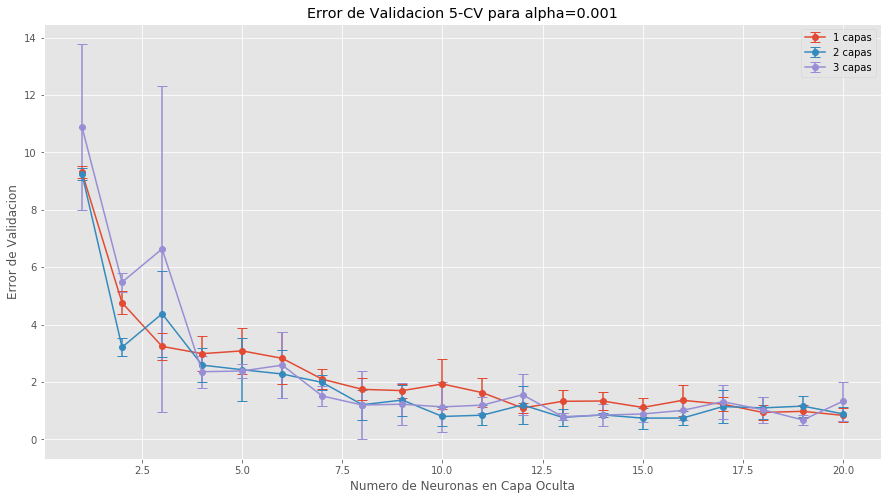

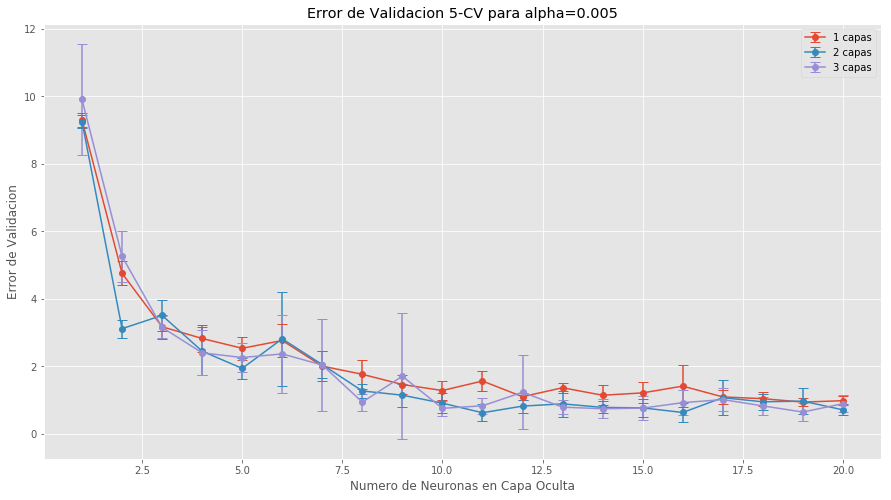

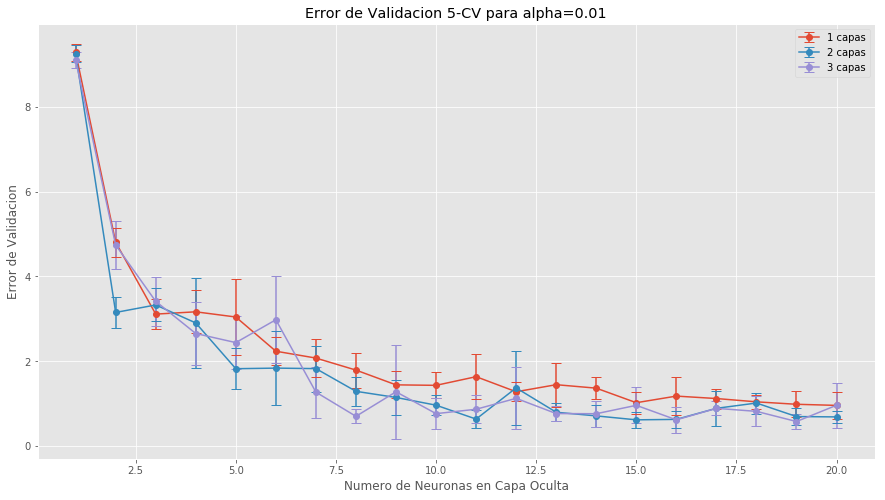

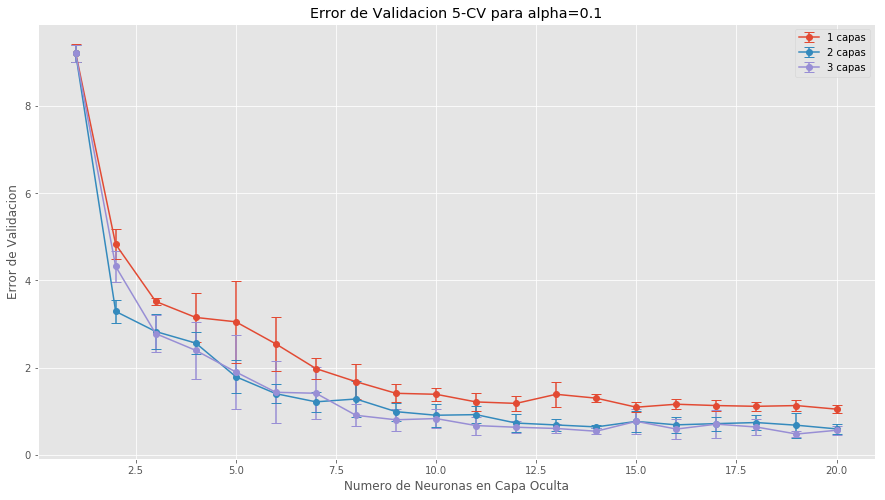

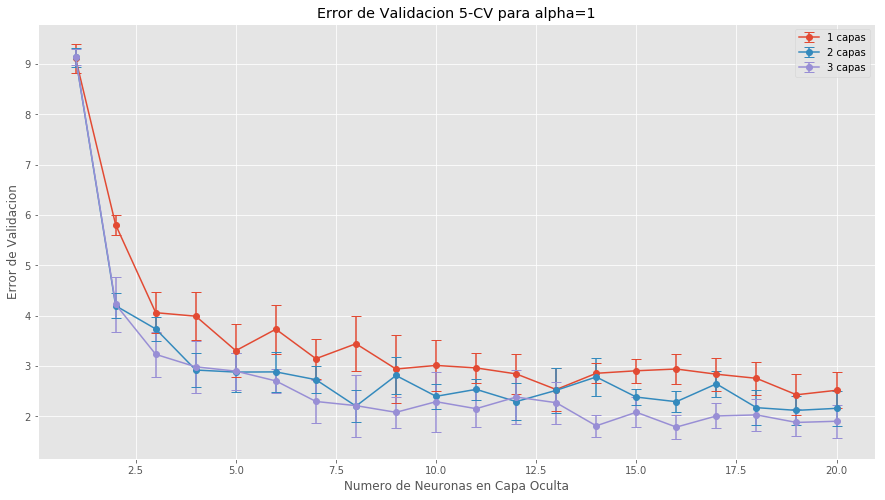

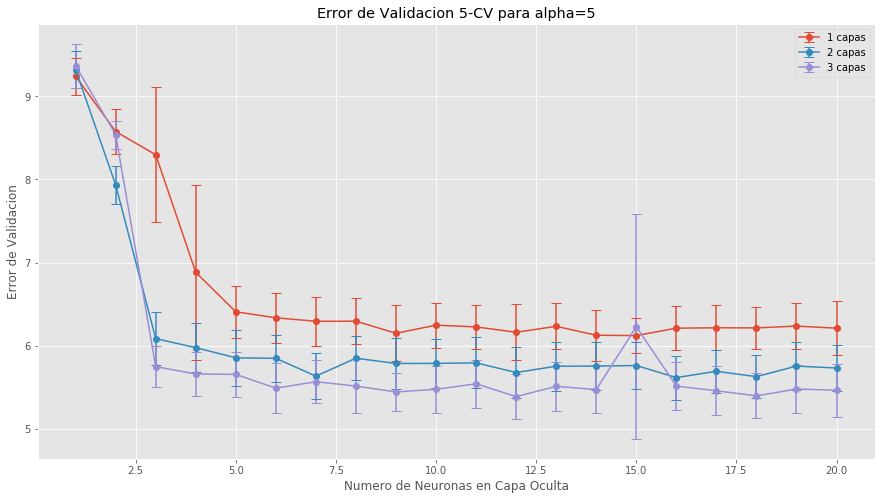

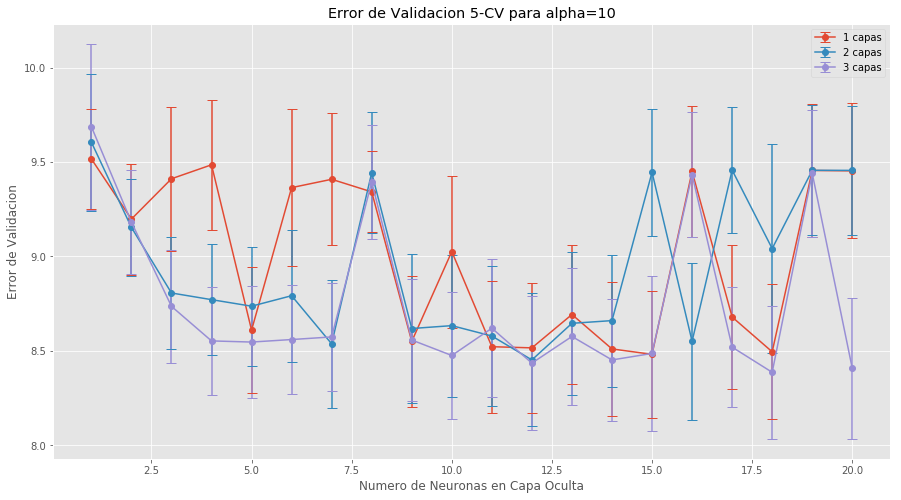

In [37]:
# Creamos un grafico para cada valor de alpha
for alpha in unique_alphas:
    plt.figure(figsize=(15, 8))
    
    for layer_count in unique_layer_counts:
        # Filtramos los resultados para una combinación específica de alpha y número de capas
        subset = cv_results[(cv_results['param_alpha'] == alpha) & (cv_results['n_layers'] == layer_count)]

        if not subset.empty:
            plt.errorbar(subset['n_neurons'], 
                         subset['mean_test_score'], 
                         yerr=subset['std_test_score'], 
                         fmt='-o', 
                         capsize=5,
                         label="{} capas".format(layer_count))

    plt.title("Error de Validacion 5-CV para alpha={}".format(alpha))
    plt.xlabel("Numero de Neuronas en Capa Oculta")
    plt.ylabel("Error de Validacion")
    plt.legend()
    plt.show()

Datos del Hiperparámetro con menor error de validación cruzada y mas simple

In [38]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
best = cv_results_best.loc[:,
                    ['param_hidden_layer_sizes', 'param_alpha',  'n_layers',  'n_neurons',
                     'mean_test_score', 'std_test_score', 'rank_test_score']
                   ].sort_values(by='param_hidden_layer_sizes', ascending=False
                    ).head(1)
best

param_hidden_layer_sizes param_alpha  n_layers  n_neurons  \
298             (19, 19, 19)         0.1         3         19   

     mean_test_score  std_test_score  rank_test_score  
298         0.476632        0.076583                1

**Muestra la gráfica del error de test frente al valor de los hiper‐parámetros (siguiendo el mismo esquema que en el apartado anterior), y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**

In [70]:
# Preparar los datos para el gráfico
unique_alphas = cv_results['param_alpha'].unique()
unique_layer_counts = cv_results['n_layers'].unique()

# Calcular los errores de test
test_errors = {alpha: {layer_count: [] for layer_count in unique_layer_counts} for alpha in unique_alphas}

for index, row in cv_results.iterrows():
    params = row['params']
    alpha = params['alpha']
    layer_count = len(params['hidden_layer_sizes'])

    model = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE, **params)
    model.fit(X_train_scaled, Y_train)
    Y_pred_test = model.predict(X_test_scaled)
    test_error = mean_squared_error(Y_test, Y_pred_test)

    test_errors[alpha][layer_count].append((row['n_neurons'], test_error))

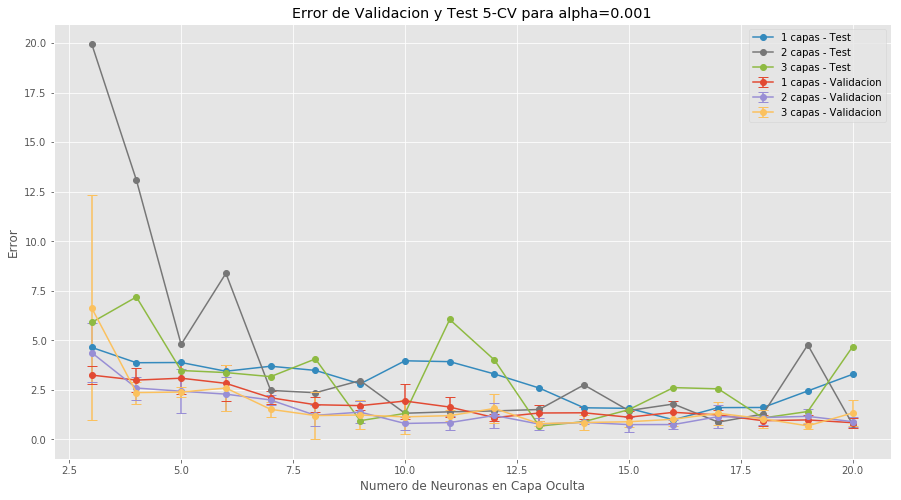

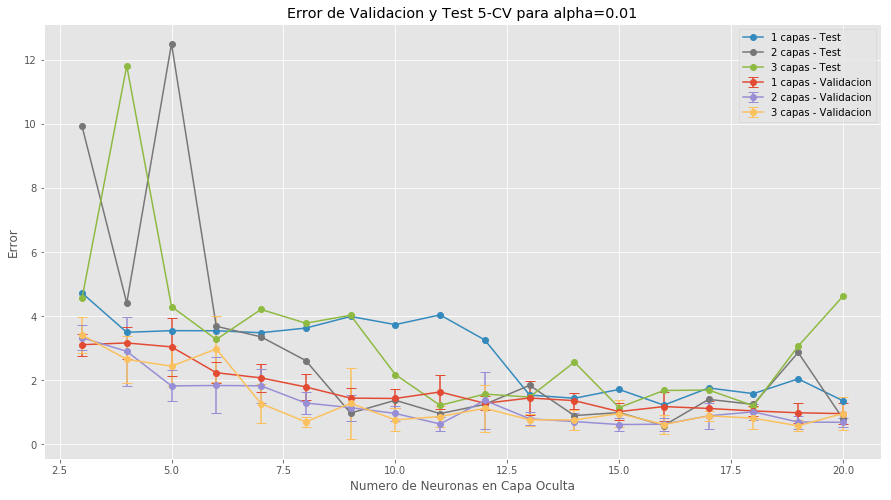

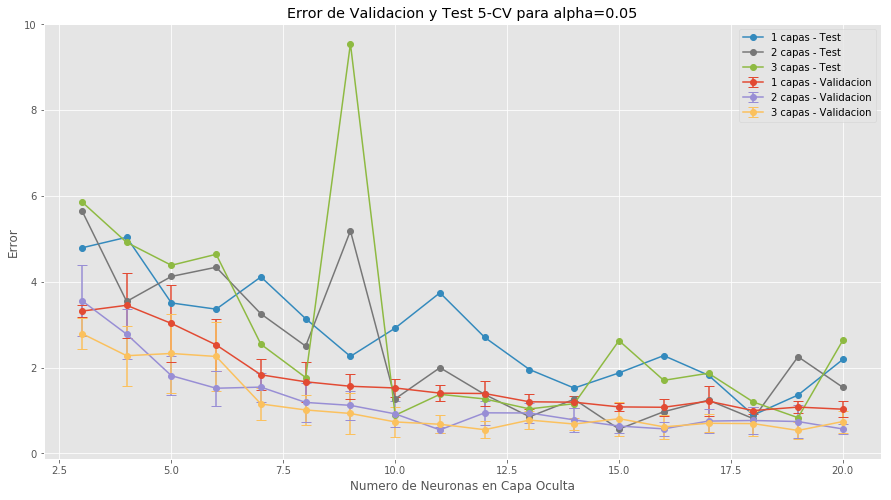

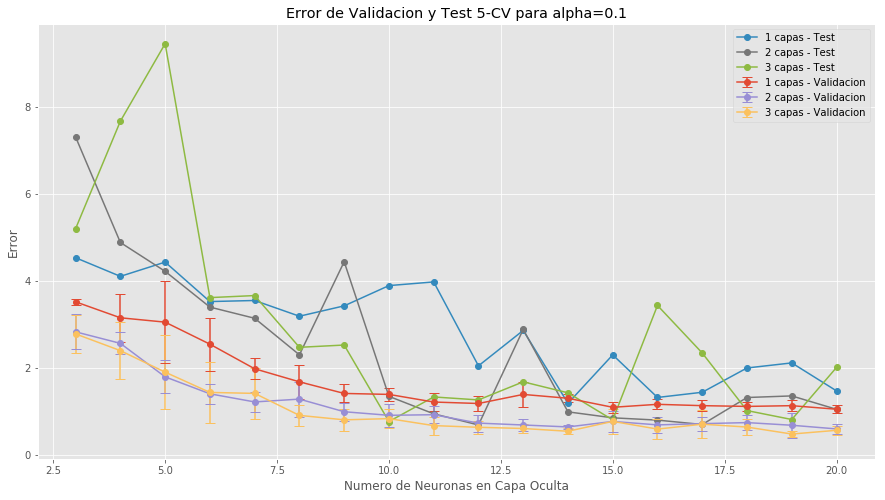

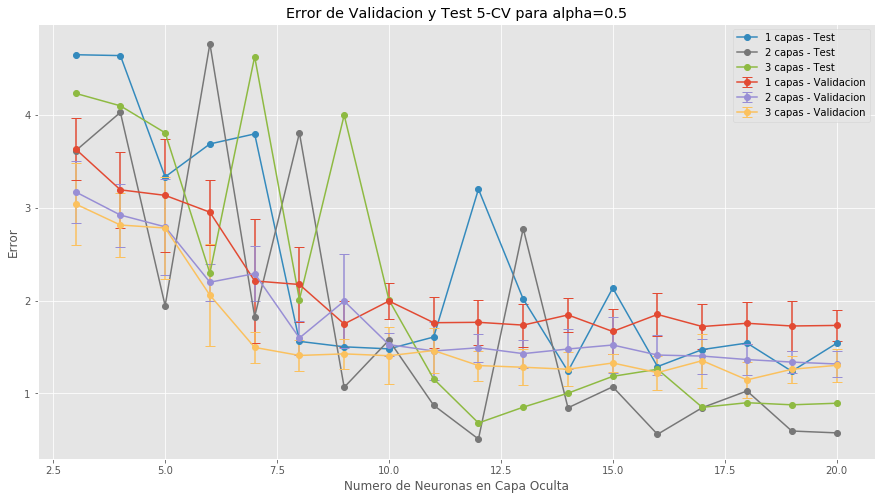

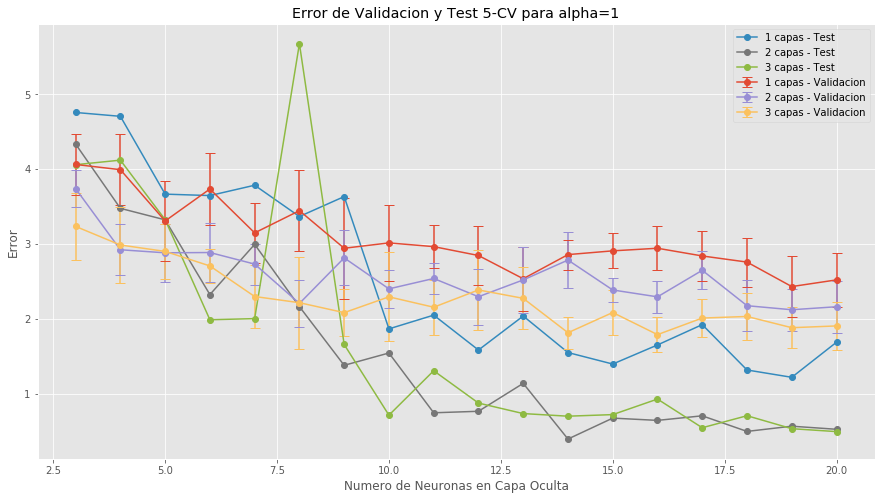

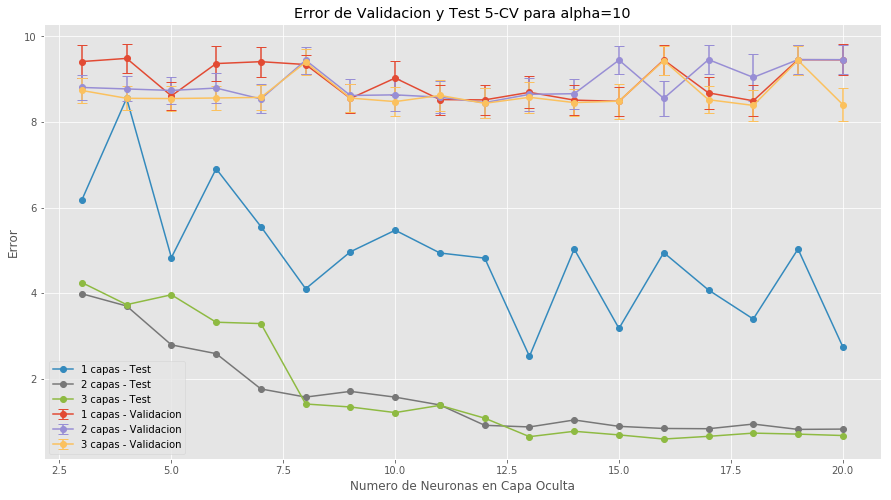

In [71]:
# Crear un gráfico para cada valor de alpha
for alpha in unique_alphas:
    plt.figure(figsize=(15, 8))

    for layer_count in unique_layer_counts:
        # Filtrar los resultados para una combinación específica de alpha y número de capas
        subset = cv_results[(cv_results['param_alpha'] == alpha) & (cv_results['n_layers'] == layer_count)]

        if not subset.empty:
            # Ignorar los 2 primeros valores de n_neurons
            subset = subset.iloc[2:]

            # Gráfico de error de validación
            plt.errorbar(subset['n_neurons'], 
                         subset['mean_test_score'], 
                         yerr=subset['std_test_score'], 
                         fmt='-o', 
                         capsize=5,
                         label="{} capas - Validacion".format(layer_count))

            # Gráfico de error de test
            test_error_data = test_errors[alpha][layer_count]
            if test_error_data:
                # Ignorar los 2 primeros valores de n_neurons
                test_error_data = test_error_data[2:]
                
                neurons, test_error_values = zip(*test_error_data)
                plt.plot(neurons, test_error_values, label="{} capas - Test".format(layer_count), marker='o')

    plt.title("Error de Validacion y Test 5-CV para alpha={}".format(alpha))
    plt.xlabel("Numero de Neuronas en Capa Oculta")
    plt.ylabel("Error")
    plt.legend()
    plt.show()


Salto los 2 primeros valores de numero de neuronas ya que introducian errores de test tan altos que impedian el estudio de los datos

Para alpha hasta 0.5 los valores de test empiezan muy alejados de los entrenados pero acaban aproximándose al crecer el valor de las neuronas por capa. Para alphas superiores los datos de test son mas estables y producen mejores resultados que la validación.

In [72]:
print("Error de test para el mejor modelo seleccionado por validación cruzada")
print(test_errors[0.1][3][18])

Error de test para el mejor modelo seleccionado por validación cruzada
(19, 0.8110551188153451)


In [73]:
encontrar_minimo_error(test_errors)

{'alpha': 1, 'error': 0.39333945998631675, 'n_layer': 2, 'n_neurons': 14}